In [1]:
from assignment2_solution import *

In [2]:
days_in_year = 252
log_xreturns = get_log_excess_returns(days_in_year)

In [3]:
time_t = np.datetime64('1996-12-31')
ng = ngarch.initialize_at(time_t, log_xreturns, days_in_year);

ngarch(
    lmbda = 0.01049,
    omega = 3.82275328782378e-07,
    alpha = 0.06253,
    beta = 0.90825,
    gamma = 0.5972,
    days_in_year = 252
)
Persistence: 0.9930811894352
Unconditional volatility: 0.11799746729790574


Consider...

In [4]:
tic()
rf      = get_risk_free_rate(time_t, days_in_year)
S_t0    = 100 # Normalize the underlying at 100
n_days  = 10*days_in_year
n_paths = 10000 
h_tp1   = 0.55**2 / days_in_year # Supposed, for instance, that vol just spiked to 55%...
#... It did *not* on 1996-12-31, but let's assume a can opener...

horizon = np.arange(1,n_days+2) / days_in_year

# In a nutshell, I here simulate excess returns and variance under P and Q
P = measure( *ng.simulateP(S_t0,n_days,n_paths,h_tp1) )
Q = measure( *ng.simulateQ(S_t0,n_days,n_paths,h_tp1,P.z) ) 
#Q: There is no theoretical reasons to use the P shocks (P.z) to simulate Q paths: The innovations under Q 
#   are random variables of their own. Numerically, however, by using the same shocks under both measures 
#   (correctly risk-adjusting the parameters otherwise of course) the simulation noise is the same in both 
#   sets of paths. See, for instance, how smooth is the ERP path plotted below

# The best return forecast at a given horizon is the average across simulated paths
P.expected_ex_r = np.mean(np.exp(P.ex_r),axis=1)-1
Q.expected_ex_r = np.mean(np.exp(Q.ex_r),axis=1)-1

# The best variance forecast at a given horizon is the average across simulated paths
P.expected_h = np.mean(P.h,axis=1)
Q.expected_h = np.mean(Q.h,axis=1)
toc();

Elapsed time: 1.259267 seconds.



In general asset pricing studies, the equity risk **premium** is the difference between **expected** returns under $\mathbb{P}$ ($e^{\mu}$) and returns under $\mathbb{Q}$ ($e^{r_f}$). The $\lambda$ parameter controls the magnitude of the equity risk premium. This can be confirmed by computing this first order approximation to the one-day-ahead  and unconditonal ERPs:

In [5]:
h = np.array([ng.uncond_var(), h_tp1])
erp = np.power(np.exp(ng.lmbda * np.sqrt(h)), days_in_year)-1
uncond_proxy = erp[0]
cond_erp = erp[1]
print('Unconditional (proxy)/Conditional ERP:',uncond_proxy,'/',cond_erp)

Unconditional (proxy)/Conditional ERP: 0.01984368094135691 / 0.09591318337044608


Clearly, the expectations below are rather noisy

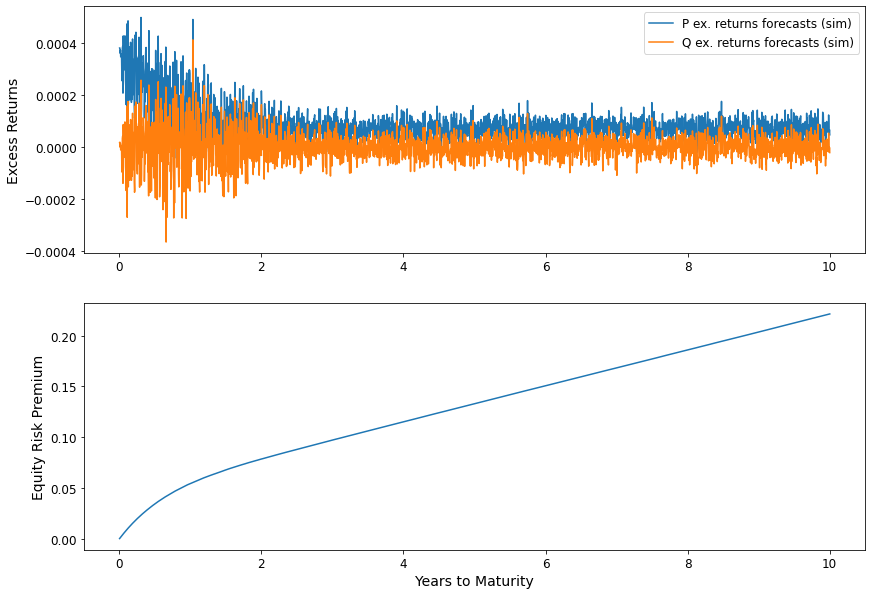

In [6]:
plot_excess_return_forecasts(horizon[:-1], P, Q);

The ERP plot above might be misleading. Because the ERP is not annualized, it seems lower at short horizons and bigger at long horizons. But variance being above its unconditional level, we'd expect the exact opposite! And this *is* what we *will* see in annualized terms below. When the picture is not annualized (above) it is expected that longer-horizon investments will cumulated more premium than shorter horizon investments. Annualizing these measures allow for a more natural comparison across the term structure.

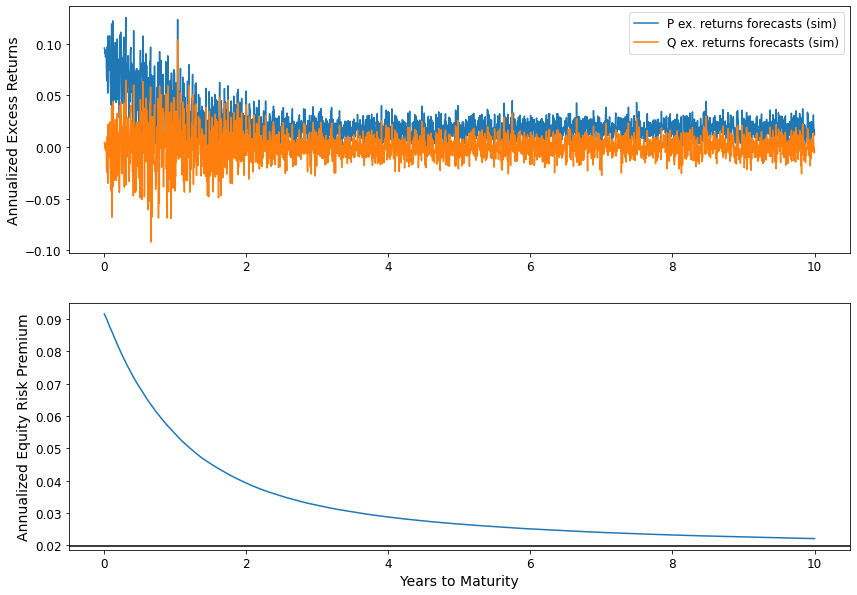

In [7]:
axes = plot_excess_return_forecasts(horizon[:-1], P, Q, annualized=True)
axes[1].axhline(uncond_proxy, color='k')